# Exploring the WWI Data Warehouse

## Configure Packages

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from matplotlib.dates import datestr2num, num2date


pd.set_option('display.max_columns', None)
sns.set_theme(context='talk', style='darkgrid', palette='deep')

## Creating a Joint Dataframe

### Reading in the Fact and Dimension Tables

In [24]:
fact_table = pd.read_csv("data/preprocessed/fact.sale.csv")
date_dimension = pd.read_csv("data/preprocessed/dim.date.csv")
product_dimension = pd.read_csv("data/preprocessed/dim.stockItem.csv")
customer_dimension = pd.read_csv("data/preprocessed/dim.customer.csv")
city_dimension = pd.read_csv("data/preprocessed/dim.city.csv")
employee_dimension = pd.read_csv("data/preprocessed/dim.employee.csv")
payment_dimension = pd.read_csv("data/preprocessed/dim.payment.csv")

### Create New Columns and Merge Tables

In [25]:
# Create column in the fact table calculating profit in millions.
fact_table["Profit (Millions)"] = fact_table["Profit"] / 1e6

# Create column in the fact table calculating profit in thousands.
fact_table["Profit (Thousands)"] = fact_table["Profit"] / 1e3

# Merge the fact and dimension tables on primary keys using an inner join.
df = fact_table.merge(
    date_dimension, left_on="Invoice Date Key", right_on="Date", suffixes=('', '_y')
).merge(
    product_dimension, on="Stock Item Key", suffixes=('', '_y')
).merge(
    customer_dimension, on="Customer Key", suffixes=('', '_y')
).merge(
    city_dimension, on="City Key", suffixes=('', '_y')
).merge(
    employee_dimension, left_on="Salesperson Key", right_on="Employee Key", suffixes=('', '_y')
)

# Drop duplicate columns.
df.drop(df.filter(regex='_y$').columns, axis=1, inplace=True)

df["Date"] = pd.to_datetime(df["Date"])

# Display table information.
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 228265 entries, 0 to 228264
Data columns (total 75 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   Sale Key                    228265 non-null  int64         
 1   City Key                    228265 non-null  int64         
 2   Customer Key                228265 non-null  int64         
 3   Bill To Customer Key        228265 non-null  int64         
 4   Stock Item Key              228265 non-null  int64         
 5   Invoice Date Key            228265 non-null  object        
 6   Delivery Date Key           227981 non-null  object        
 7   Salesperson Key             228265 non-null  int64         
 8   WWI Invoice ID              228265 non-null  int64         
 9   Description                 228265 non-null  object        
 10  Package                     228265 non-null  object        
 11  Quantity                    228265 non-

## Exploring How Profits Have Evolved Over Time

In [26]:
# Calculate total profits by each month in the fiscal year.
profits_by_fiscal_month = df.groupby(
    ["Fiscal Year", "Month", "Fiscal Month Number"]
    )[
        ["Profit", "Profit (Millions)"]
    ].sum().reset_index().sort_values(["Fiscal Month Number"])

# Calculate total profits in each fiscal year.
profits_by_fiscal_year = df.groupby(
    "Fiscal Year"
    )[
        ["Profit", "Profit (Millions)"]
    ].sum().reset_index().sort_values(["Fiscal Year"])

### Total Profit (in Millions) Generated Each Fiscal Year

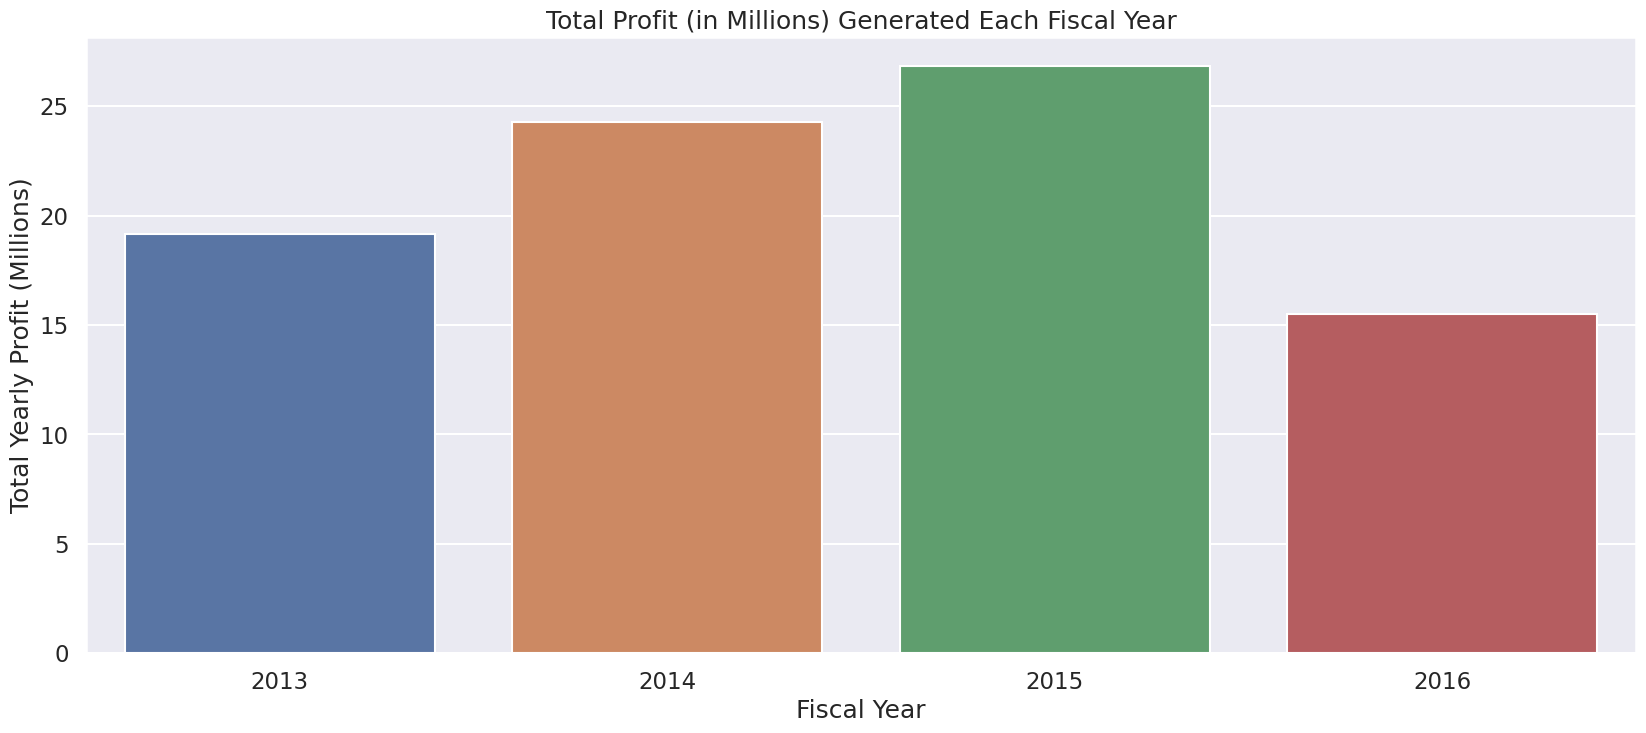

In [27]:
figure, ax = plt.subplots(
    figsize=(20,8)
)

sns.barplot(
    x="Fiscal Year",
    y="Profit (Millions)",
    data=profits_by_fiscal_year,
    ax=ax,
)

plt.ylabel("Total Yearly Profit (Millions)")
plt.title("Total Profit (in Millions) Generated Each Fiscal Year");

### Total Monthly Profit (in Millions) By Fiscal Year

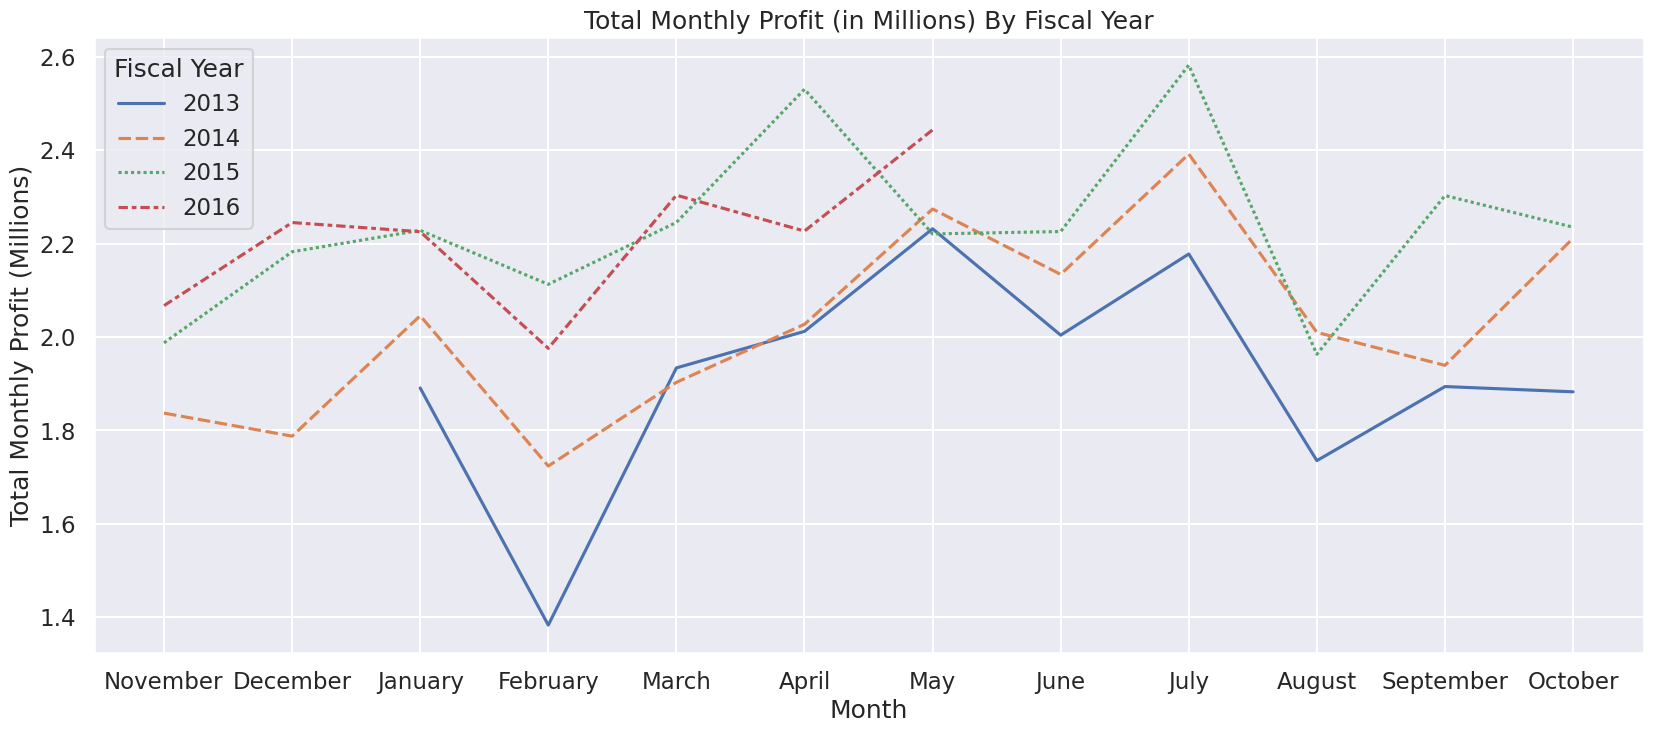

In [28]:
figure, ax = plt.subplots(
    figsize=(20,8)
)

sns.lineplot(
    x="Month",
    y="Profit (Millions)",
    data=profits_by_fiscal_month,
    hue="Fiscal Year",
    style="Fiscal Year",
    palette="deep",
    ax=ax,
)
plt.ylabel("Total Monthly Profit (Millions)")
plt.title("Total Monthly Profit (in Millions) By Fiscal Year");

### Average Monthly Profit (in Millions) By Fiscal Year

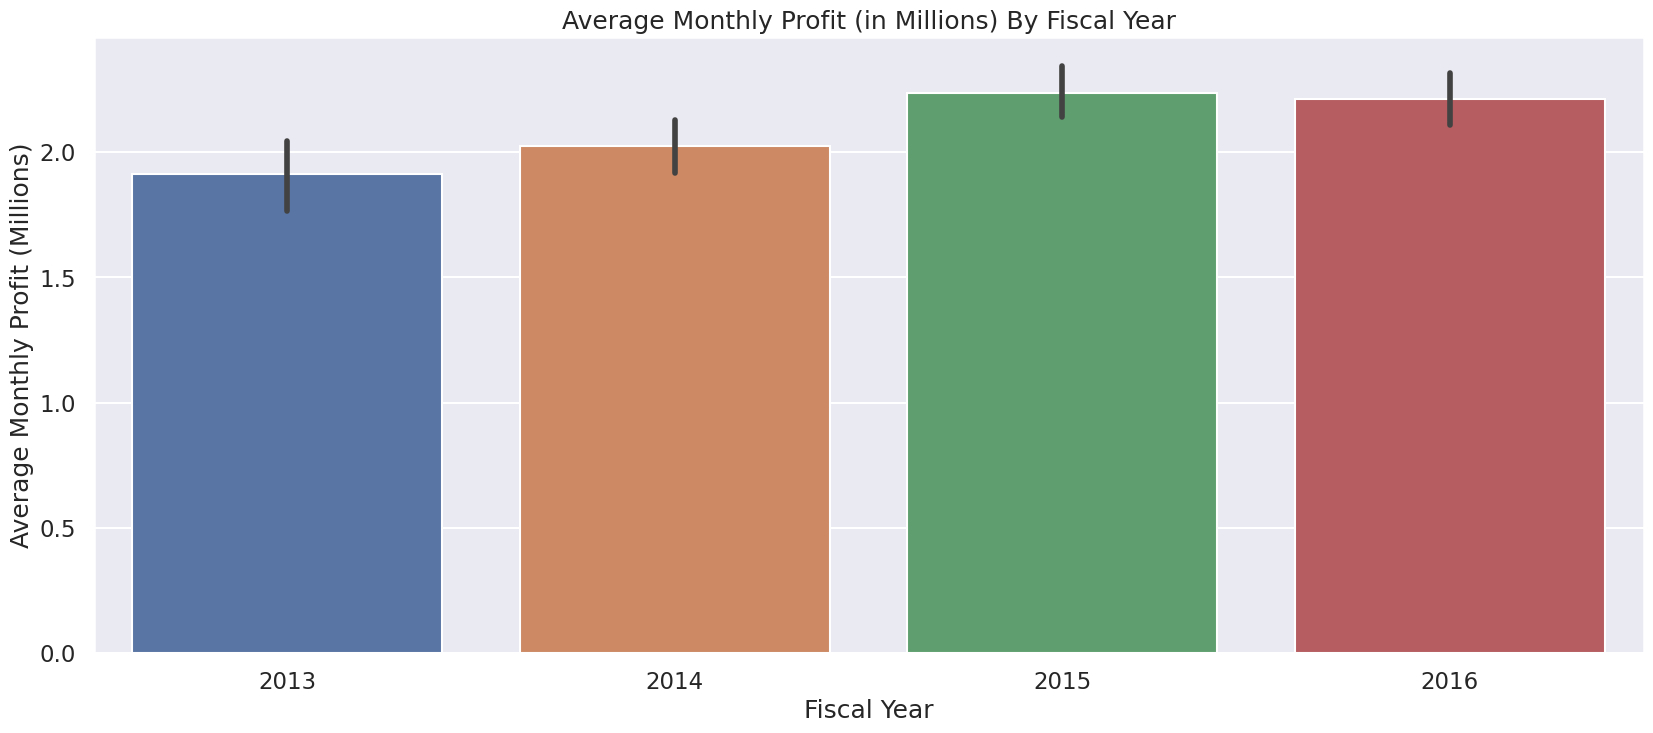

In [29]:
figure, ax = plt.subplots(
    figsize=(20,8)
)

sns.barplot(
    x="Fiscal Year",
    y="Profit (Millions)",
    data=profits_by_fiscal_month,
    ax=ax,
)

plt.ylabel("Average Monthly Profit (Millions)")
plt.title("Average Monthly Profit (in Millions) By Fiscal Year");

### What is the Estimated Average Growth Rate in Profits?

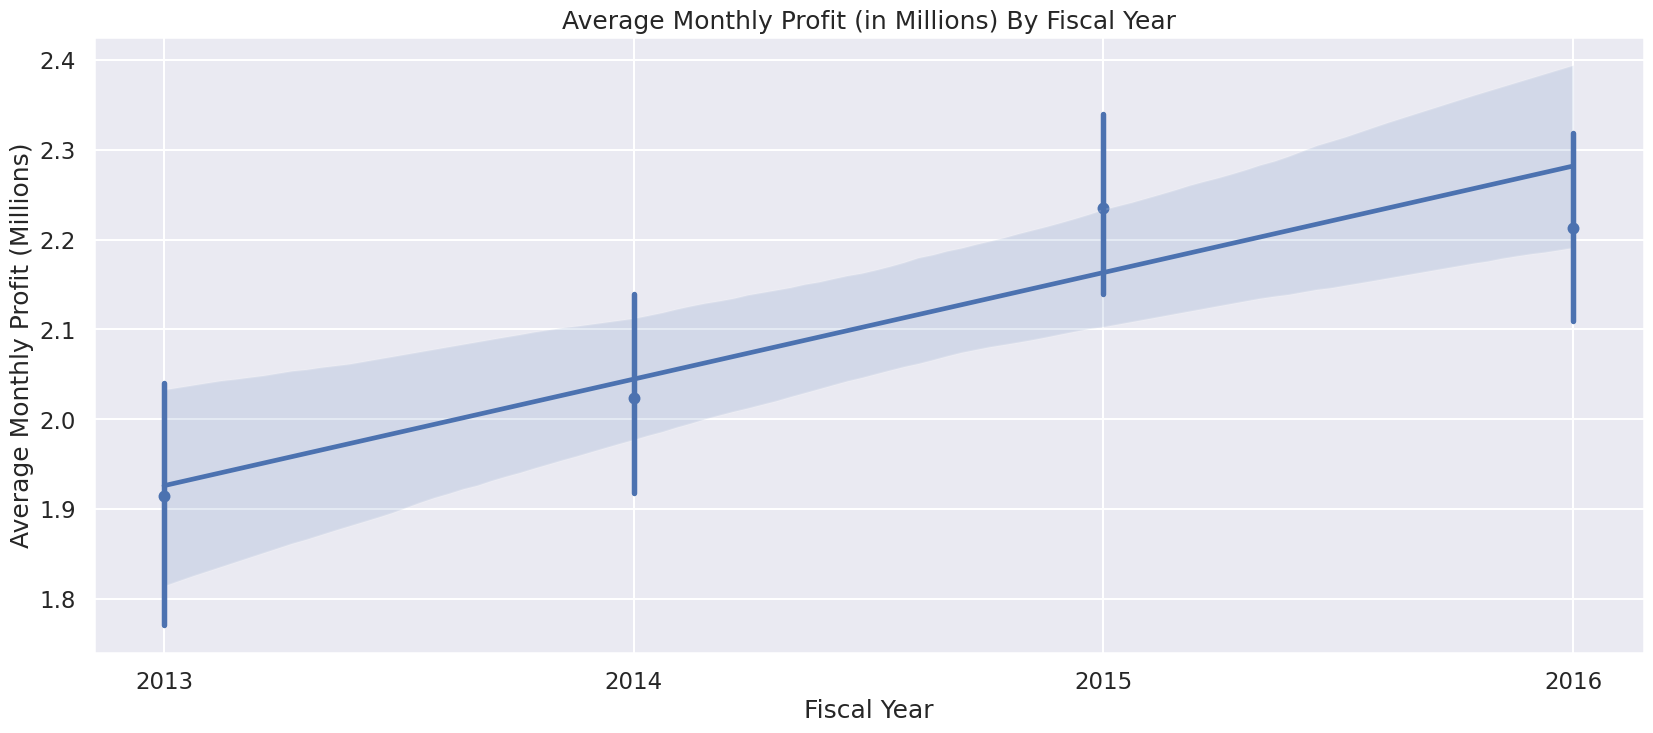

In [30]:
figure, ax = plt.subplots(
    figsize=(20,8)
)

sns.regplot(
    x="Fiscal Year",
    y="Profit (Millions)",
    data=profits_by_fiscal_month,
    x_estimator=np.mean,
    ax=ax,
)
plt.xticks(profits_by_fiscal_month["Fiscal Year"].unique())
plt.ylabel("Average Monthly Profit (Millions)")
plt.title("Average Monthly Profit (in Millions) By Fiscal Year");

#### Average Monthly Profits Per Year

In [31]:
x = profits_by_fiscal_month["Fiscal Year"]
y = profits_by_fiscal_month["Profit (Millions)"]

x = sm.add_constant(x)
model = sm.OLS(y, x)
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Profit (Millions)   R-squared:                       0.283
Model:                            OLS   Adj. R-squared:                  0.264
Method:                 Least Squares   F-statistic:                     15.38
Date:                Fri, 06 Jan 2023   Prob (F-statistic):           0.000346
Time:                        13:23:37   Log-Likelihood:                 8.8282
No. Observations:                  41   AIC:                            -13.66
Df Residuals:                      39   BIC:                            -10.23
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        -236.8241     60.916     -3.888      0.000    -360.039    -113.609
Fiscal Year     0.1186      0.030      3.922      0.000       0.057       0.180
==============================================================================
Omnibus:                        1.124   Durbin-Watson:                   0.917
Prob(Omnibus):                  0.570   Jarque-Bera (JB):                0.396
Skew:                          -0.154   Prob(JB):                        0.820
Kurtosis:                       3.371   Cond. No.                     3.93e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.93e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [32]:
print("Estimated Average Monthly Growth Rate:")
print(f"${(results.params[1]*1000).round(-1)}K (+- ${(results.bse[1]*1000).round(-1)}K) per year")
print("Yearly Profit Gain:")
print(f"${(results.params[1]*12).round(1)}M (+- {(results.bse[1]*1000*12).round(-2)}K)")

Estimated Average Monthly Growth Rate:
$120.0K (+- $30.0K) per year
Yearly Profit Gain:
$1.4M (+- 400.0K)


In [33]:
future = np.arange(2016, 2027)
future = sm.add_constant(future)

monthly_profit_predictions = results.predict(future)

print("Predicted Average Monthly Profits:")
for i, monthly_profit in enumerate(monthly_profit_predictions):
    print(f"{int(future[i][1])}: ~ ${monthly_profit.round(1)}M per month -> ~ ${(monthly_profit*12).round(1)}M per year")

Predicted Average Monthly Profits:
2016: ~ $2.3M per month -> ~ $27.4M per year
2017: ~ $2.4M per month -> ~ $28.8M per year
2018: ~ $2.5M per month -> ~ $30.2M per year
2019: ~ $2.6M per month -> ~ $31.7M per year
2020: ~ $2.8M per month -> ~ $33.1M per year
2021: ~ $2.9M per month -> ~ $34.5M per year
2022: ~ $3.0M per month -> ~ $35.9M per year
2023: ~ $3.1M per month -> ~ $37.3M per year
2024: ~ $3.2M per month -> ~ $38.8M per year
2025: ~ $3.3M per month -> ~ $40.2M per year
2026: ~ $3.5M per month -> ~ $41.6M per year


#### Average Daily Profits Per Month

In [34]:
profits_by_date = df.groupby(
    ["Date"]
    )[
        ["Profit", "Profit (Thousands)"]
    ].sum().reset_index().sort_values(["Date"])
    
profits_by_date["Month"] = profits_by_date["Date"].dt.to_period('M').astype(str)

profits_by_date["monthnum"] = datestr2num(profits_by_date["Month"])

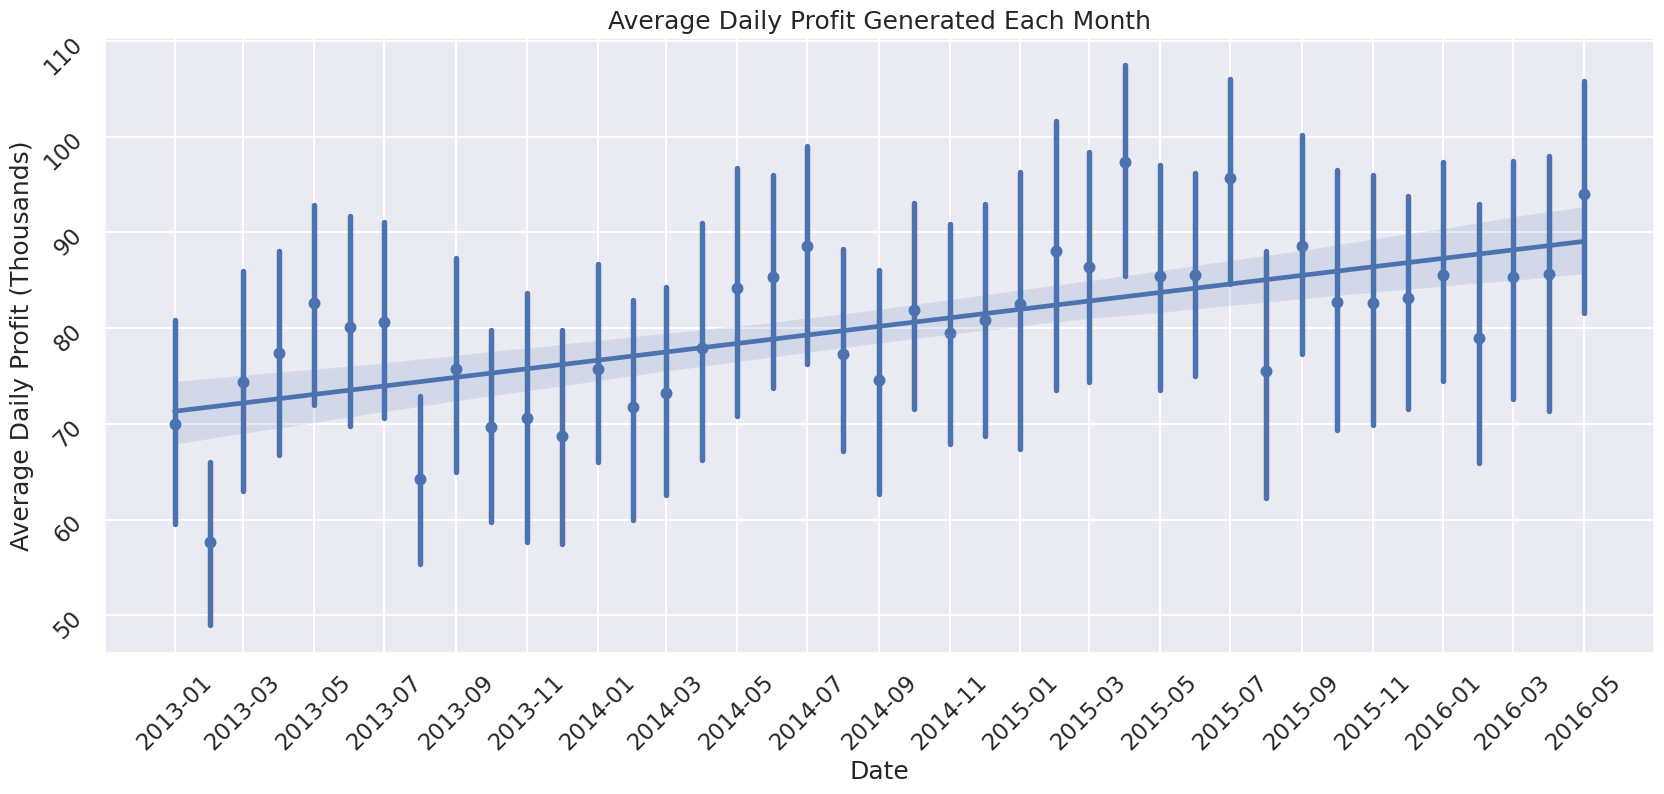

In [35]:
@plt.FuncFormatter
def fake_dates(x, pos):
    """ Custom formater to turn floats into e.g., 2016-05-08"""
    return num2date(x).strftime('%Y-%m')

figure, ax = plt.subplots(
    figsize=(20,8)
)

ax.xaxis.set_major_formatter(fake_dates)
ax.tick_params(labelrotation=45)

sns.regplot(
    x="monthnum",
    y="Profit (Thousands)",
    data=profits_by_date,
    x_estimator=np.mean,
    order=1,
    ax=ax,
)

plt.xticks(profits_by_date["monthnum"].unique()[::2])
plt.xlabel("Date")
plt.ylabel("Average Daily Profit (Thousands)")
plt.title("Average Daily Profit Generated Each Month");

In [36]:
profits_by_date["month_code"] = profits_by_date["Month"].astype("category").cat.codes

In [65]:
x = profits_by_date["month_code"]
y = profits_by_date["Profit (Thousands)"]

x = sm.add_constant(x)
model = sm.OLS(y, x)
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     Profit (Thousands)   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     30.67
Date:                Fri, 06 Jan 2023   Prob (F-statistic):           3.85e-08
Time:                        13:45:34   Log-Likelihood:                -5187.9
No. Observations:                1069   AIC:                         1.038e+04
Df Residuals:                    1067   BIC:                         1.039e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         71.3022      1.865     38.223      0.000      67.642      74.962
month_code     0.4444      0.080      5.538      0.000       0.287       0.602
==============================================================================
Omnibus:                       87.608   Durbin-Watson:                   2.118
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               29.734
Skew:                           0.087   Prob(JB):                     3.49e-07
Kurtosis:                       2.202   Cond. No.                         45.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [66]:
print("Estimated Average Daily Growth Rate:")
print(f"${(results.params[1]*1000).round()} (+- ${(results.bse[1]*1000).round()}) per month")

Estimated Average Daily Growth Rate:
$444.0 (+- $80.0) per month


In [70]:
future = [f"2016-{x}" for x in range(6,13)] 
future_code = [40 + i for i in range(1,8)] # Numerical representation for months 2016-5 to 2016-12.
future_code = sm.add_constant(future_code)

daily_profit_predictions = results.predict(future_code)

print("Predicted Average Daily Profits:")
for i, daily_profit in enumerate(daily_profit_predictions):
    print(f"{future[i]}: ~ ${daily_profit.round(1)}K per day -> ~ ${(daily_profit*365/12/1000).round(1)}M per month")

Predicted Average Daily Profits:
2016-6: ~ $89.5K per day -> ~ $2.7M per month
2016-7: ~ $90.0K per day -> ~ $2.7M per month
2016-8: ~ $90.4K per day -> ~ $2.7M per month
2016-9: ~ $90.9K per day -> ~ $2.8M per month
2016-10: ~ $91.3K per day -> ~ $2.8M per month
2016-11: ~ $91.7K per day -> ~ $2.8M per month
2016-12: ~ $92.2K per day -> ~ $2.8M per month


## What Are the Most Profitable Products?

### All Time Most Profitable

In [41]:
total_profit_per_product = df.groupby("Stock Item")["Profit (Millions)"].sum()

top_products_all_time = total_profit_per_product.nlargest(25).reset_index()
bottom_products_all_time = total_profit_per_product.nsmallest(25).reset_index()

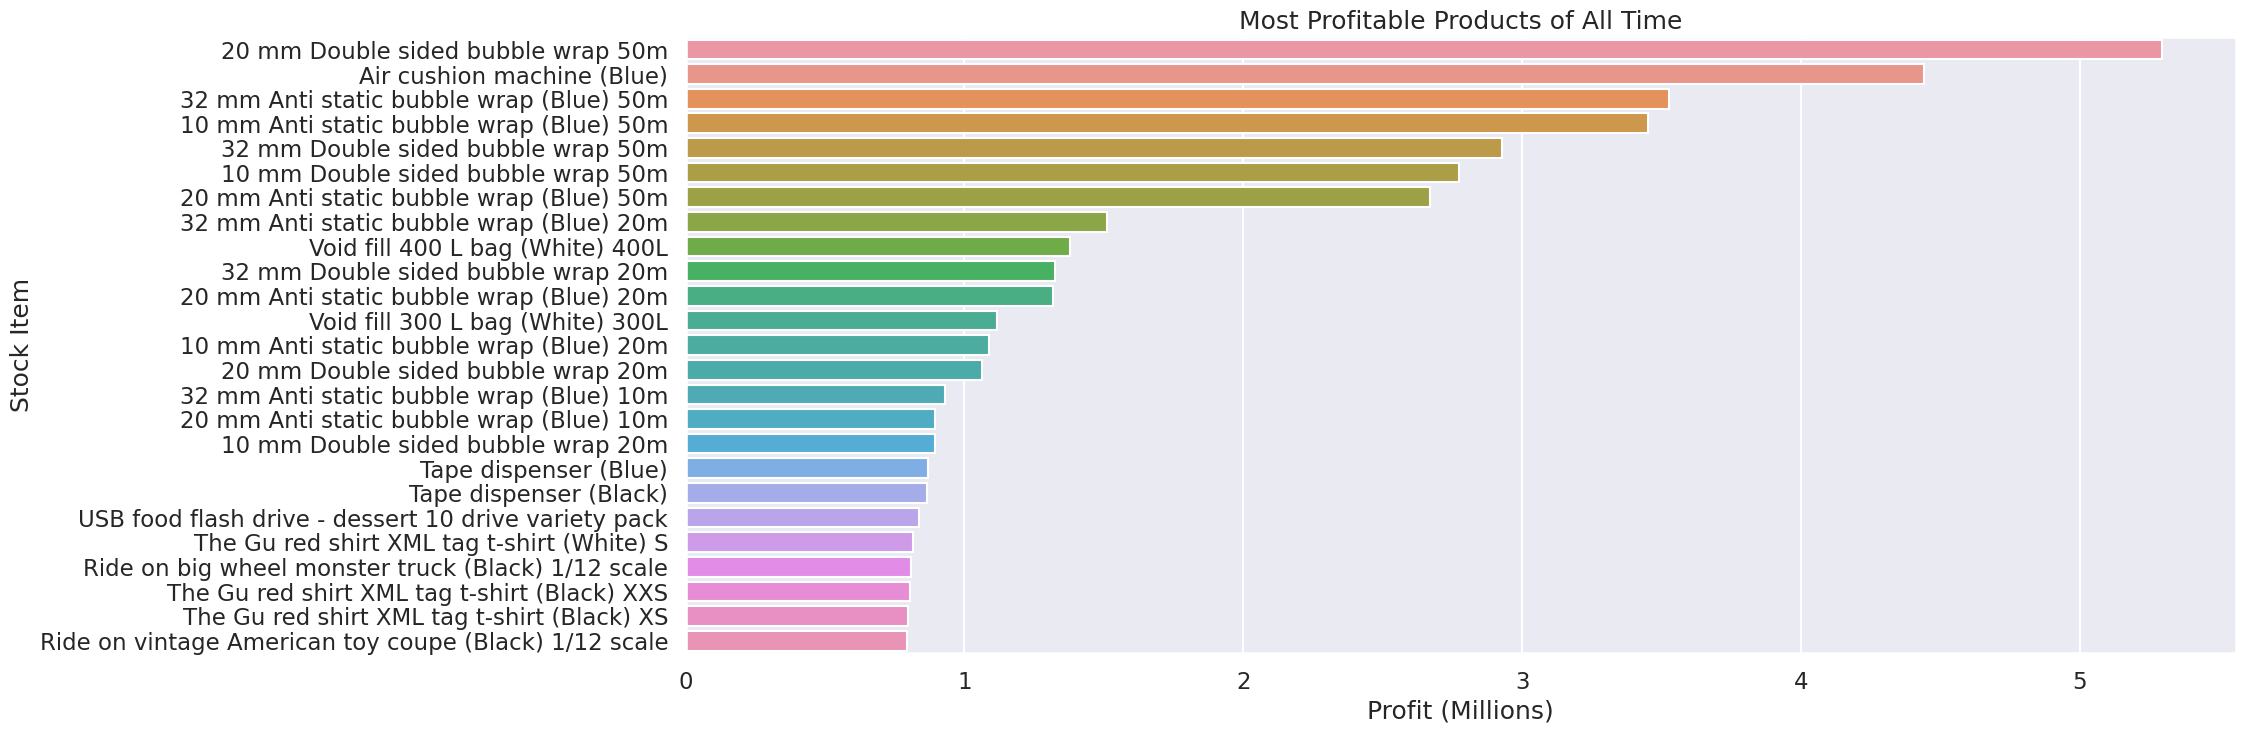

In [42]:
figure, ax = plt.subplots(
    figsize=(20,8)
)

sns.barplot(
    y="Stock Item",
    x="Profit (Millions)",
    data=top_products_all_time,
    ax=ax,
)

plt.title("Most Profitable Products of All Time");

### All Time Least Profitable

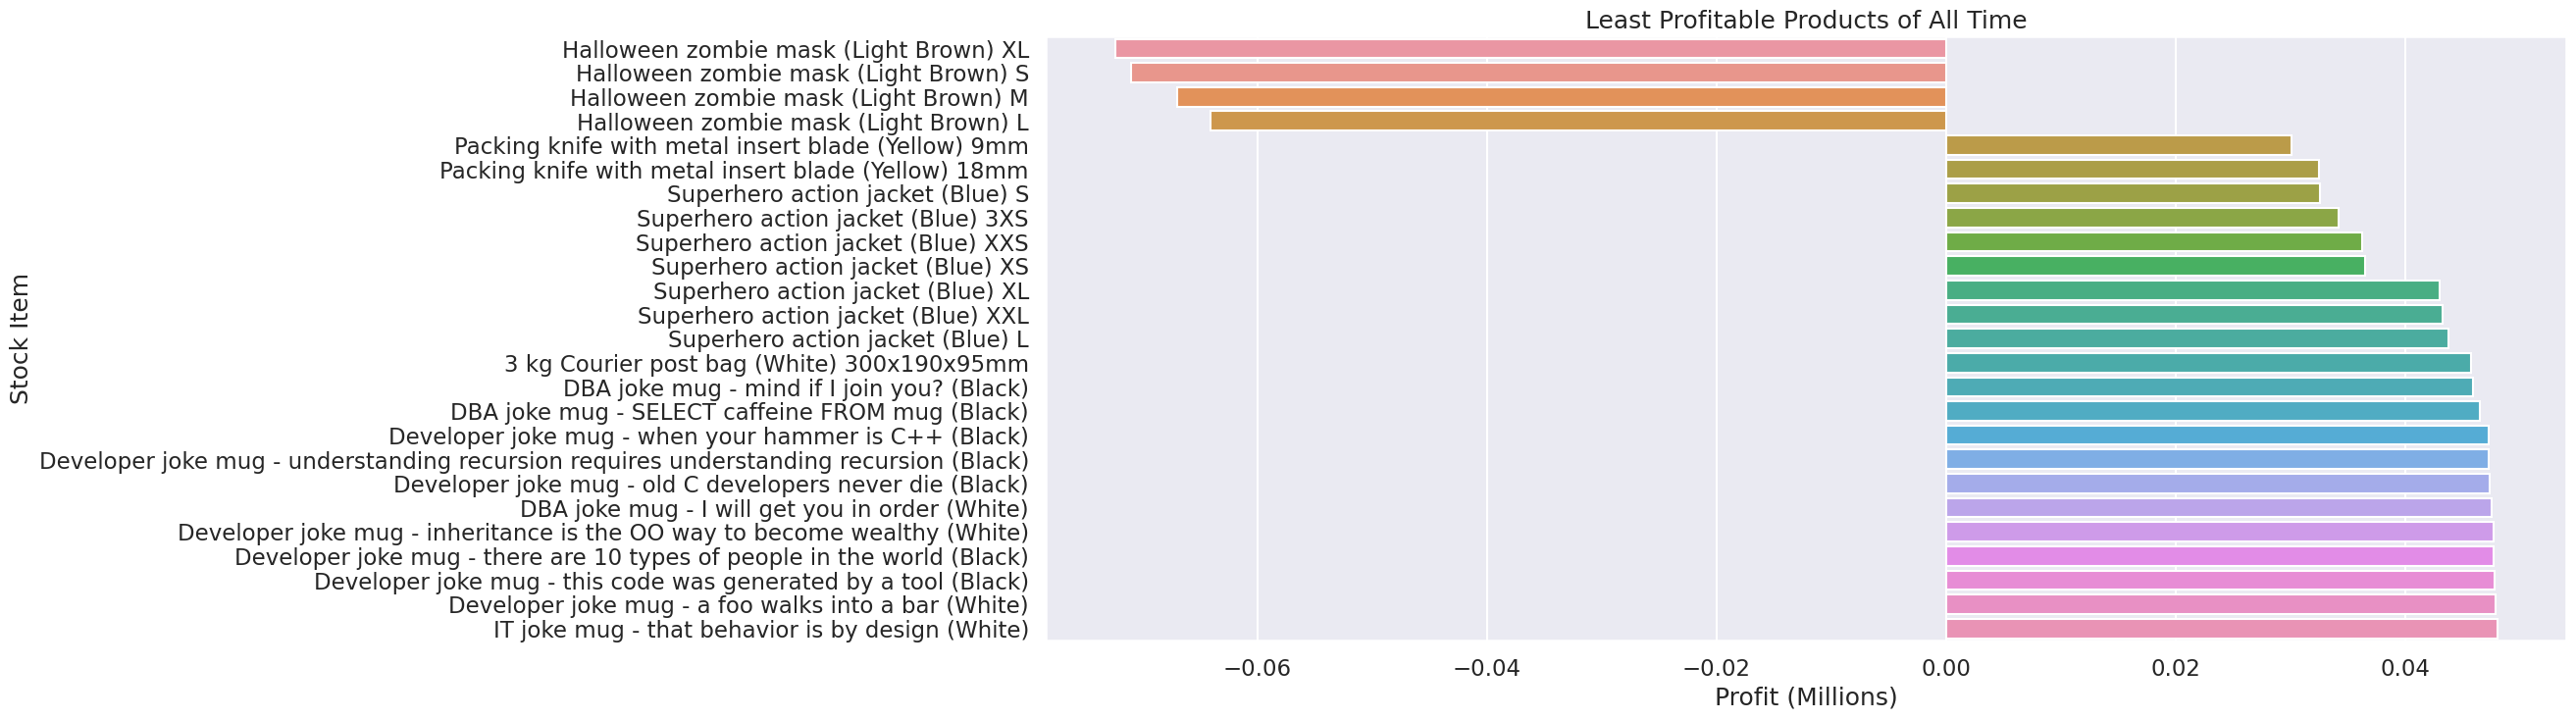

In [43]:
figure, ax = plt.subplots(
    figsize=(20,8)
)

sns.barplot(
    y="Stock Item",
    x="Profit (Millions)",
    data=bottom_products_all_time,
    ax=ax,
)

plt.title("Least Profitable Products of All Time");

## Who Are Our Most Profitable Customers?

In [44]:
total_profit_per_buying_group = df.groupby("Buying Group", dropna=False)["Profit (Millions)"].sum().reset_index().fillna("Unknown")

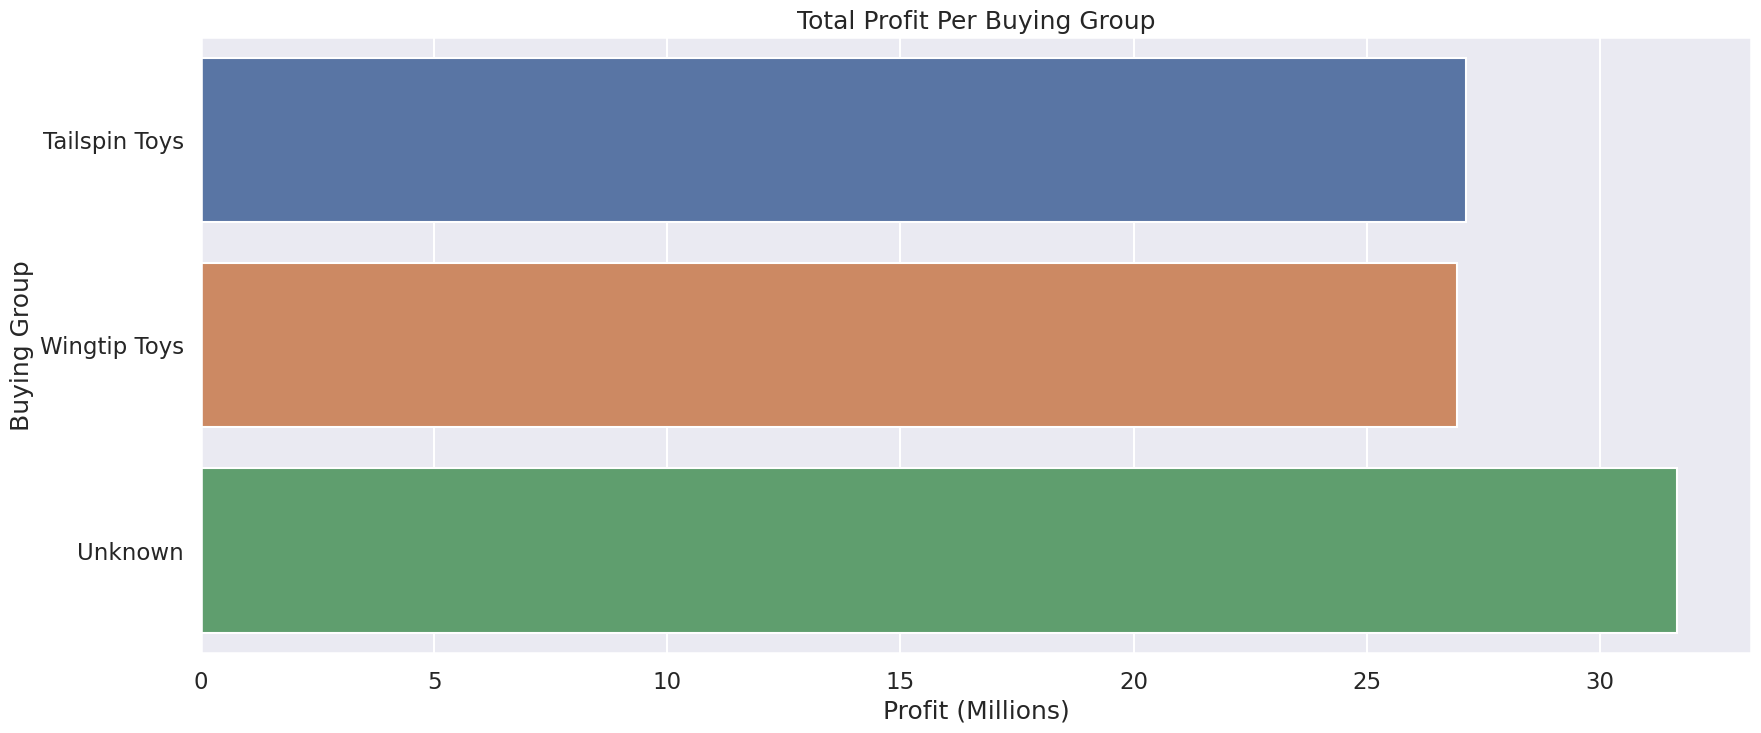

In [45]:
figure, ax = plt.subplots(
    figsize=(20,8)
)

sns.barplot(
    y="Buying Group",
    x="Profit (Millions)",
    data=total_profit_per_buying_group,
    ax=ax,
)

plt.title("Total Profit Per Buying Group");

In [46]:
total_profit_per_customer = df.groupby("Customer", dropna=False)["Profit (Millions)"].sum().nlargest(25).reset_index()

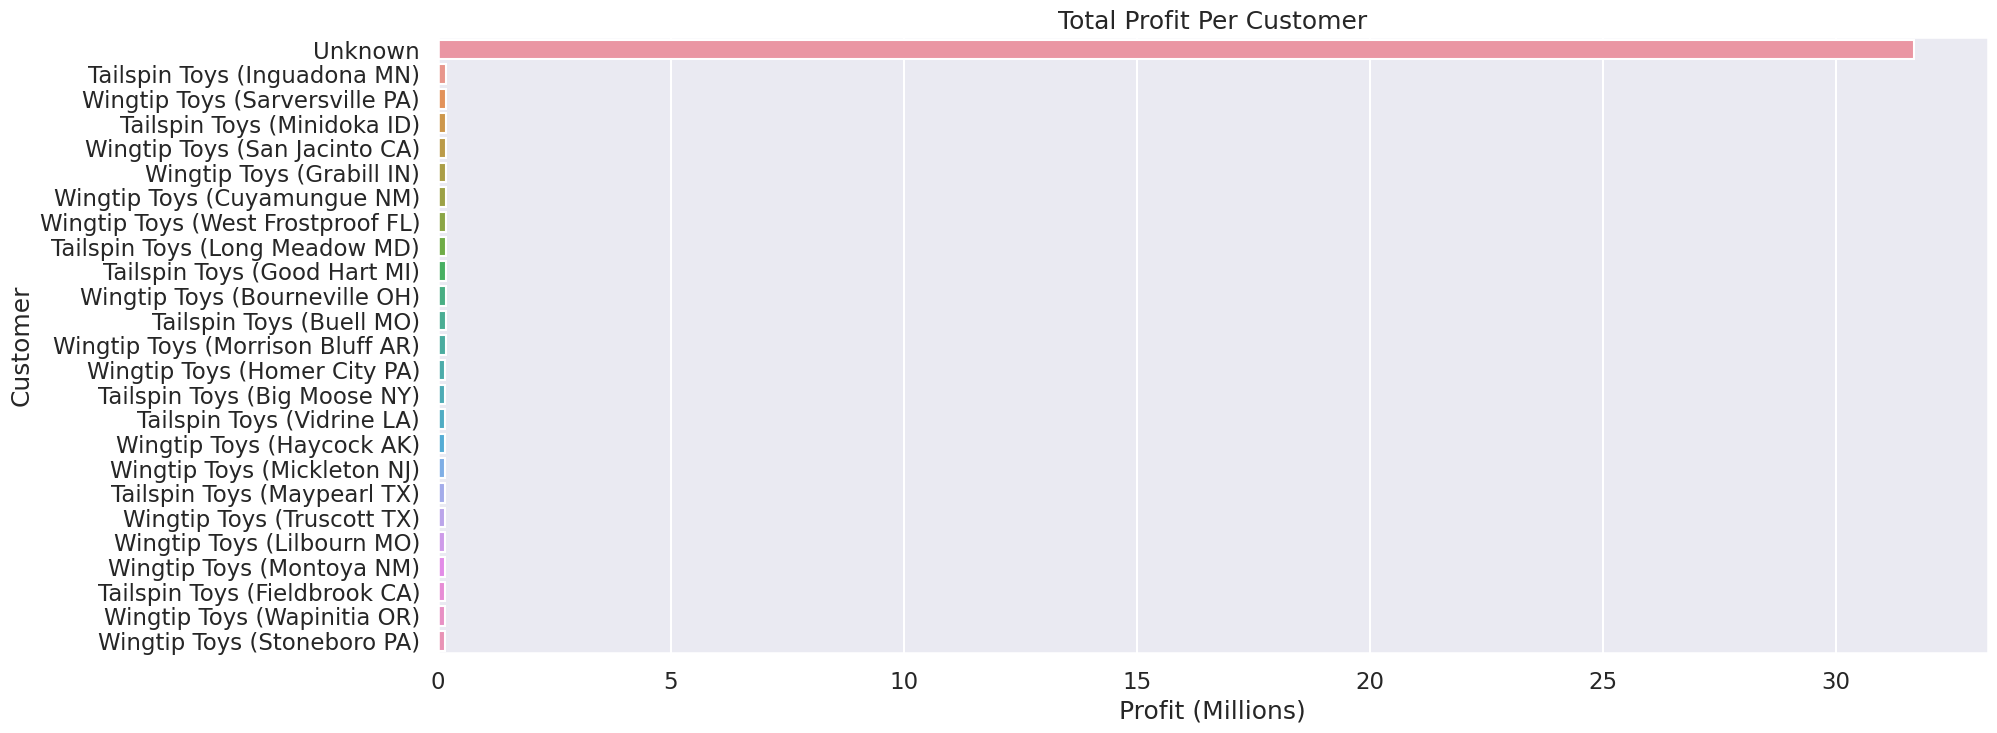

In [47]:
figure, ax = plt.subplots(
    figsize=(20,8)
)

sns.barplot(
    y="Customer",
    x="Profit (Millions)",
    data=total_profit_per_customer,
    ax=ax,
)

plt.title("Total Profit Per Customer");

## Most Profitable Locations

### All Time

In [48]:
total_profit_per_state = df.groupby("State Province", dropna=False)["Profit (Millions)"].sum().sort_values(ascending=False).reset_index().fillna("Unknown")

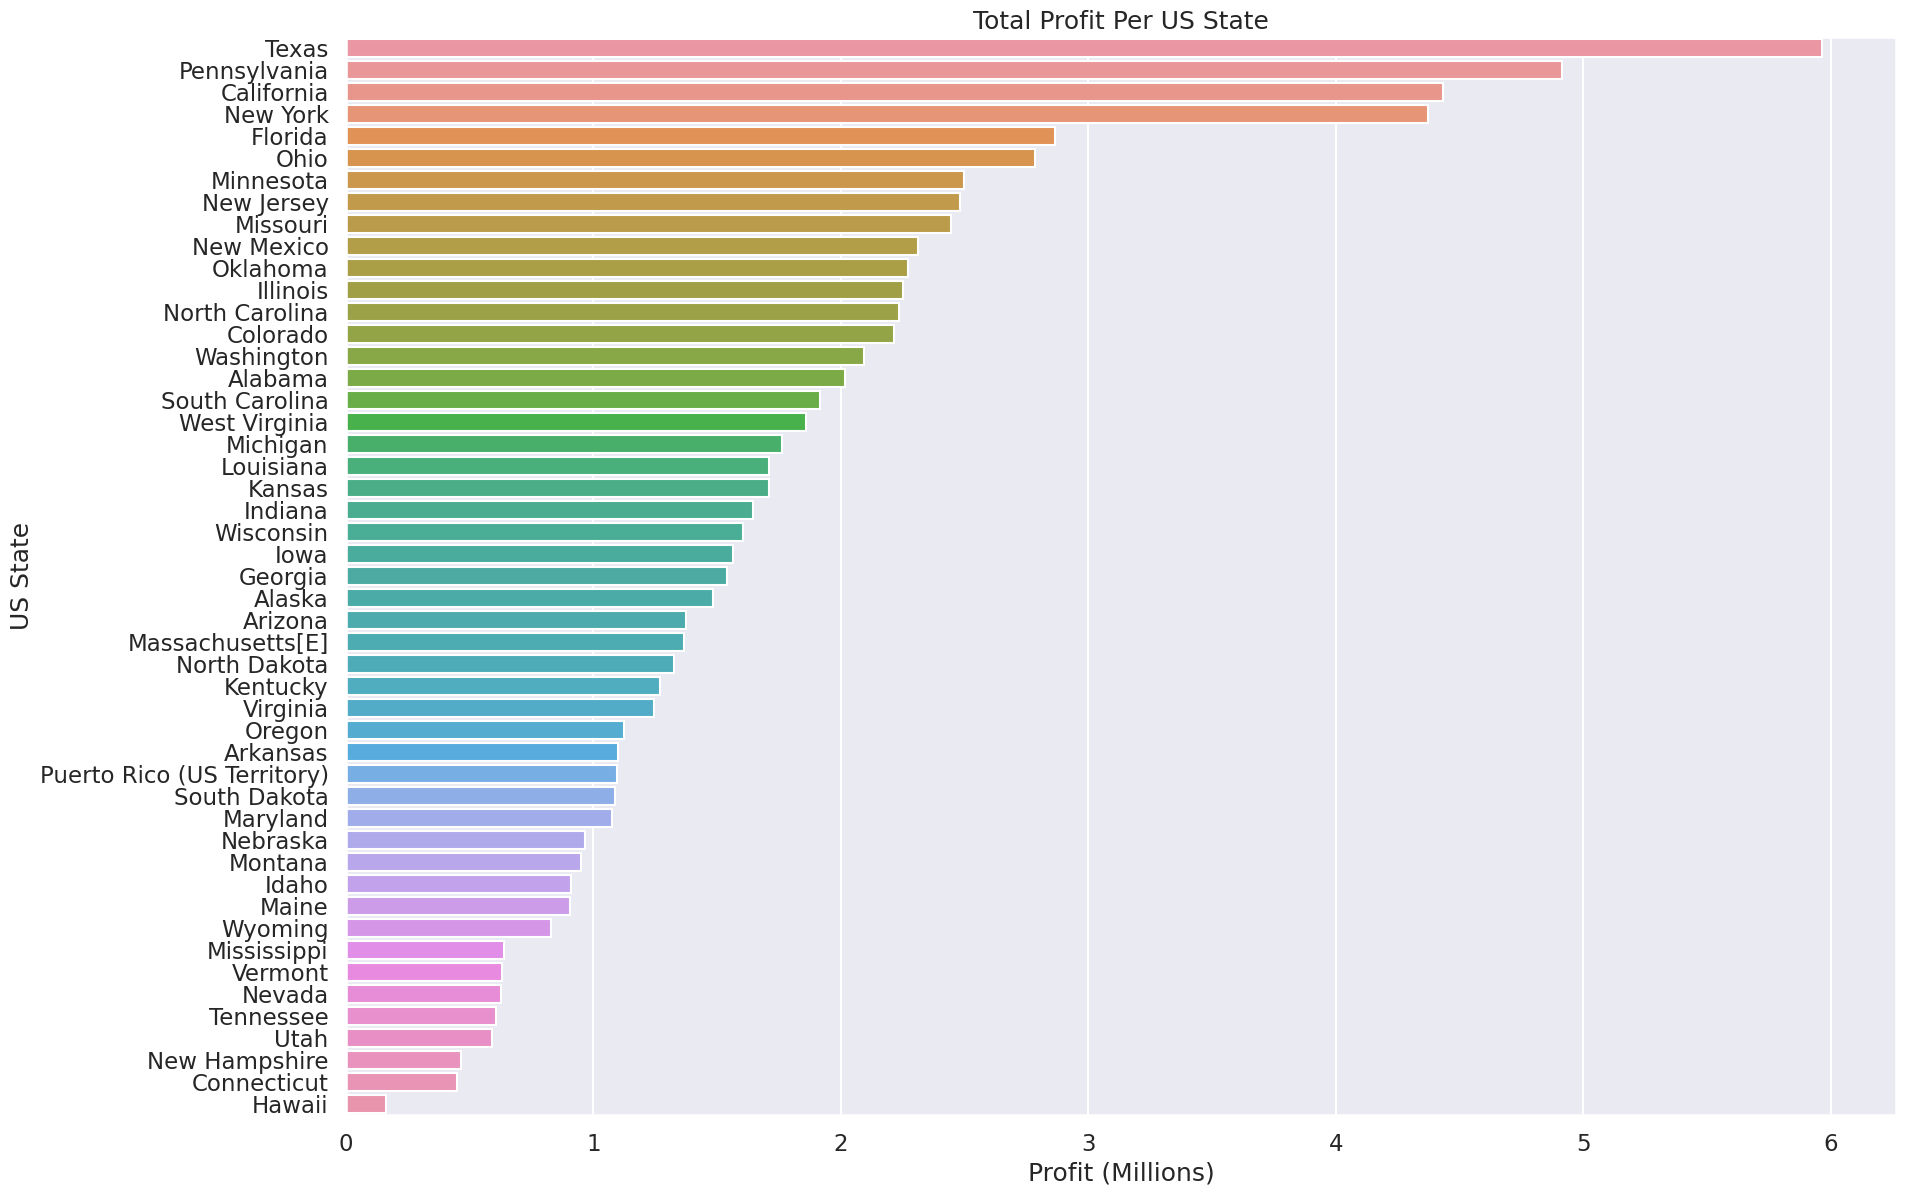

In [49]:
figure, ax = plt.subplots(
    figsize=(20,14)
)

sns.barplot(
    y="State Province",
    x="Profit (Millions)",
    data=total_profit_per_state,
    ax=ax,
)

plt.ylabel("US State")
plt.title("Total Profit Per US State");

### Yearly Profits Per State

In [50]:
yearly_profit_per_state = df.groupby(["State Province", "Fiscal Year"], dropna=False)["Profit (Millions)"].sum().sort_values(ascending=False).reset_index().fillna("Unknown")

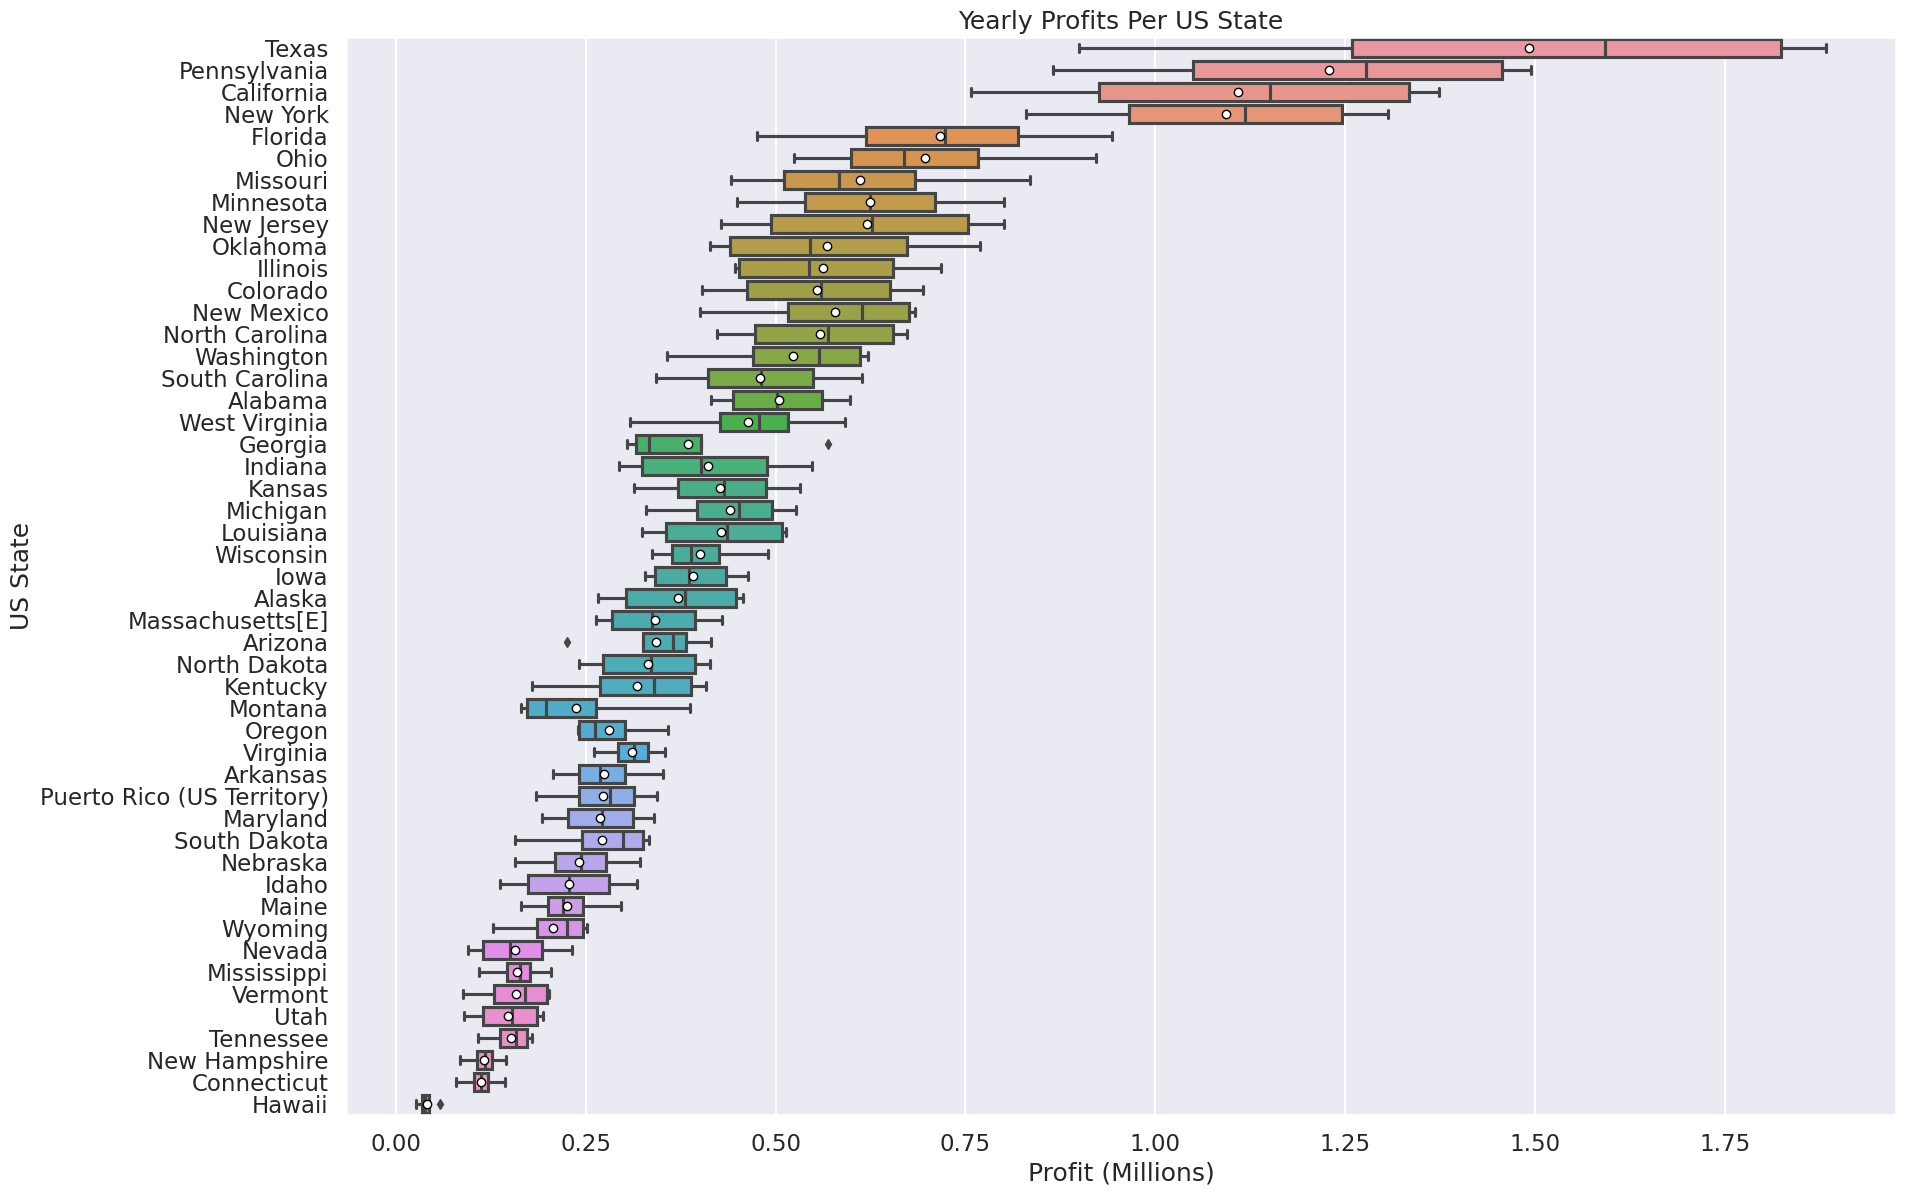

In [51]:
figure, ax = plt.subplots(
    figsize=(20,14)
)

sns.boxplot(
    y="State Province",
    x="Profit (Millions)",
    data=yearly_profit_per_state,
    showmeans=True,
    meanprops={
        "marker": "o",
        "markerfacecolor": "white",
        "markeredgecolor": "black",
    },
    ax=ax,
)

plt.ylabel("US State")
plt.title("Yearly Profits Per US State");

### Monthly Profits Per State

In [52]:
monthly_profit_per_state = df.groupby(["State Province", "Date", "Fiscal Year"], dropna=False)["Profit (Thousands)"].sum().sort_values(ascending=False).reset_index().fillna("Unknown")
monthly_profit_per_state["Date"] = monthly_profit_per_state["Date"].dt.to_period('M').astype(str)

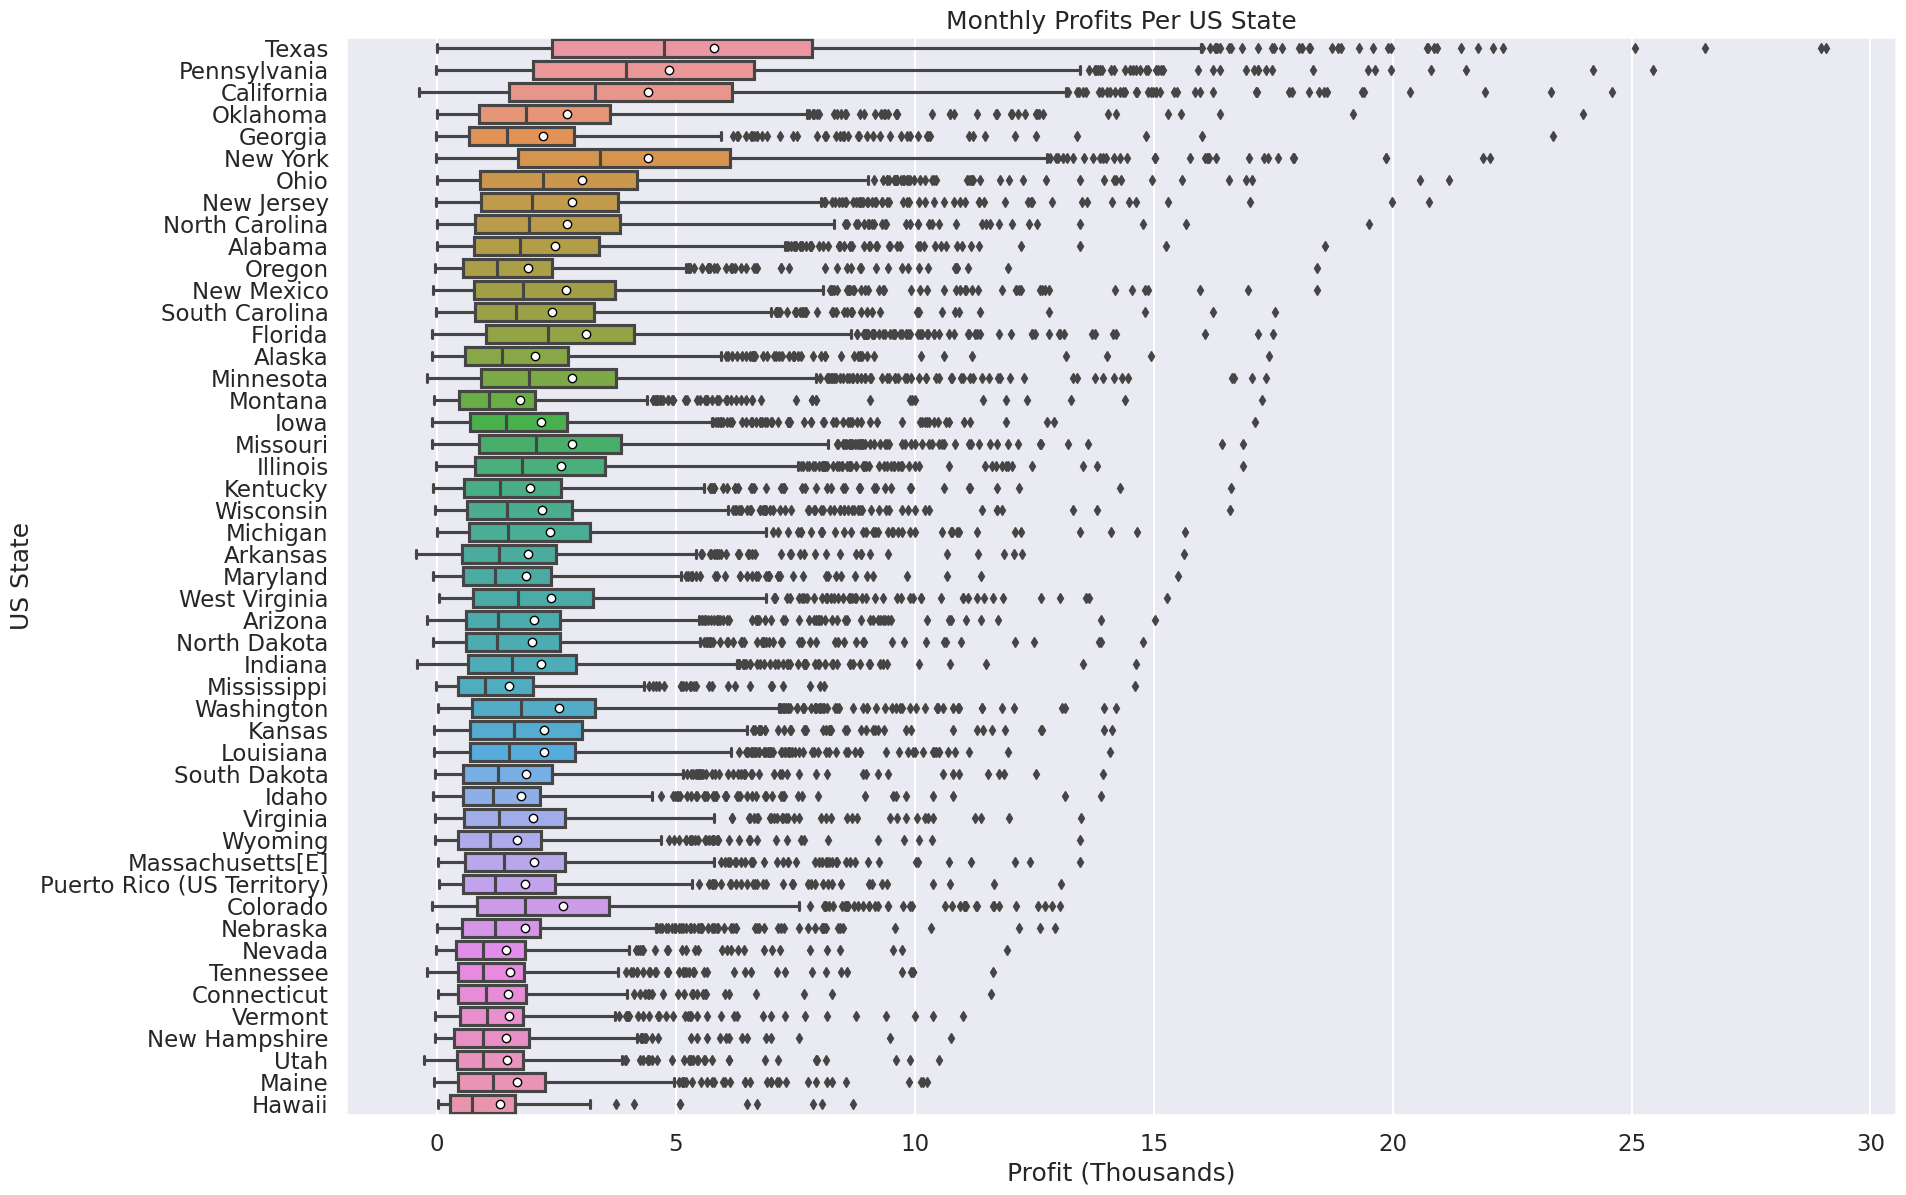

In [53]:
figure, ax = plt.subplots(
    figsize=(20,14)
)

sns.boxplot(
    y="State Province",
    x="Profit (Thousands)",
    data=monthly_profit_per_state,
    showmeans=True,
    meanprops={
        "marker": "o",
        "markerfacecolor": "white",
        "markeredgecolor": "black",
    },
    ax=ax,
)

plt.ylabel("US State")
plt.title("Monthly Profits Per US State");

### Evaluating Profit Trends in Texas

In [54]:
texas_monthly_profits = monthly_profit_per_state[monthly_profit_per_state["State Province"] == "Texas"]

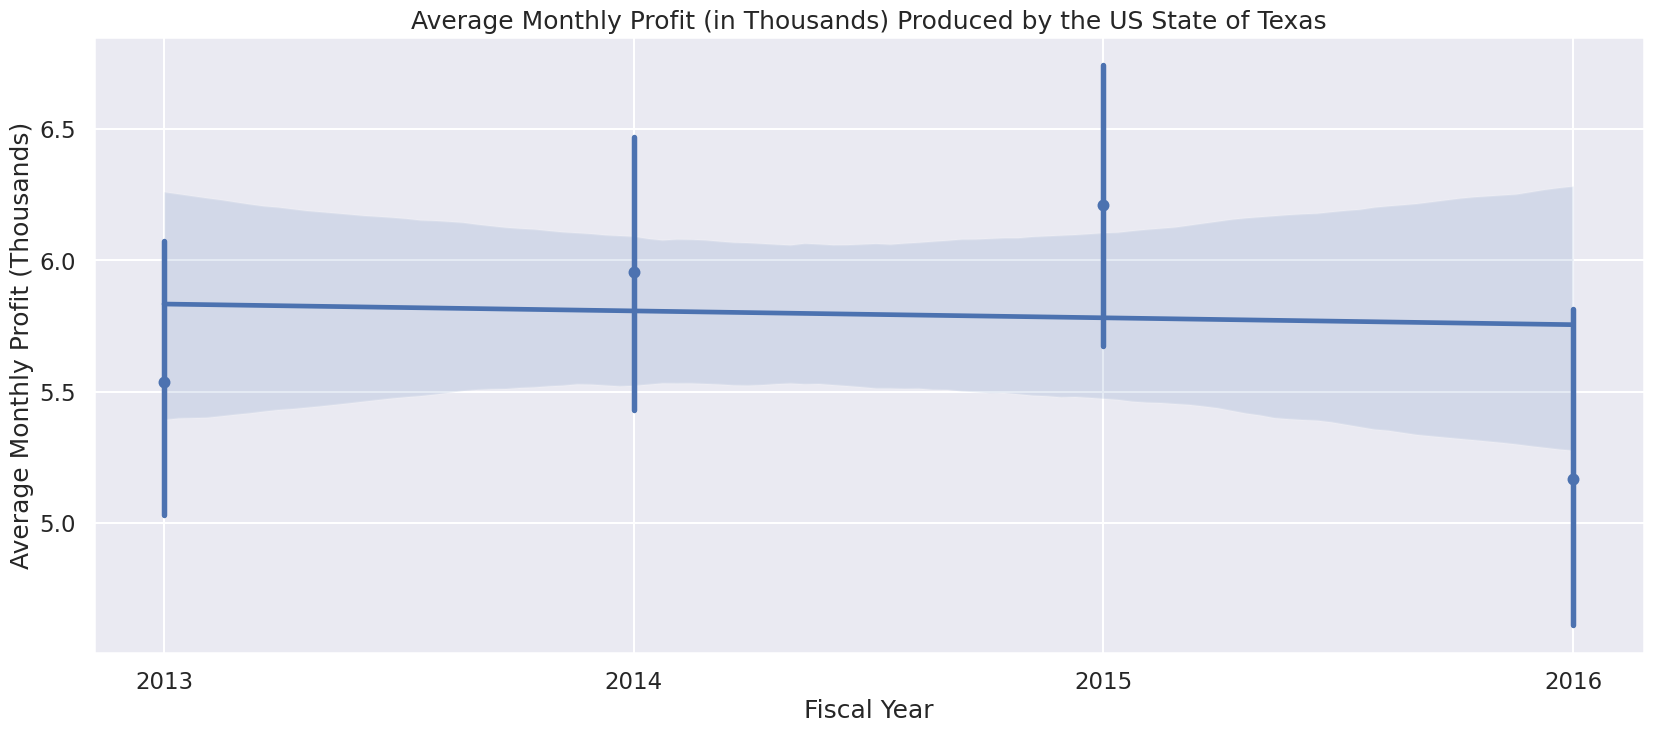

In [55]:
figure, ax = plt.subplots(
    figsize=(20,8)
)

sns.regplot(
    x="Fiscal Year",
    y="Profit (Thousands)",
    data=texas_monthly_profits,
    x_estimator=np.mean,
    order=1,
    ax=ax,
)
plt.xticks(texas_monthly_profits["Fiscal Year"].unique())
plt.ylabel("Average Monthly Profit (Thousands)")
plt.title("Average Monthly Profit (in Thousands) Produced by the US State of Texas");

#### Estimating Profit Growth

In [56]:
x = texas_monthly_profits["Fiscal Year"]
y = texas_monthly_profits["Profit (Thousands)"]

x = sm.add_constant(x)
model = sm.OLS(y, x)
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     Profit (Thousands)   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                   0.03695
Date:                Fri, 06 Jan 2023   Prob (F-statistic):              0.848
Time:                        13:23:55   Log-Likelihood:                -3007.8
No. Observations:                1029   AIC:                             6020.
Df Residuals:                    1027   BIC:                             6029.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          58.5996    274.709      0.213      0.831    -480.456     597.655
Fiscal Year    -0.0262      0.136     -0.192      0.848      -0.294       0.241
==============================================================================
Omnibus:                      270.386   Durbin-Watson:                   0.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              636.157
Skew:                           1.413   Prob(JB):                    7.25e-139
Kurtosis:                       5.616   Cond. No.                     3.94e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.94e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [57]:
print("Estimated Average Monthly Growth Rate:")
print(f"${(results.params[1]*1000).round()} (+- ${(results.bse[1]*1000).round(0)}) per year")
print("Yearly Profit Gain:")
print(f"${(results.params[1]*1000*12).round()} (+- {(results.bse[1]*1000*12).round()})")

Estimated Average Monthly Growth Rate:
$-26.0 (+- $136.0) per year
Yearly Profit Gain:
$-315.0 (+- 1636.0)


## Most Profitable Salespeople

In [58]:
# Replacing employee names with numbers. 
df["Employee"] = df["Employee"].astype("category").cat.codes

### All Time

In [59]:
total_profit_per_employee= df.groupby("Employee", dropna=False)["Profit (Millions)"].sum().sort_values(ascending=False).reset_index().fillna("Unknown")

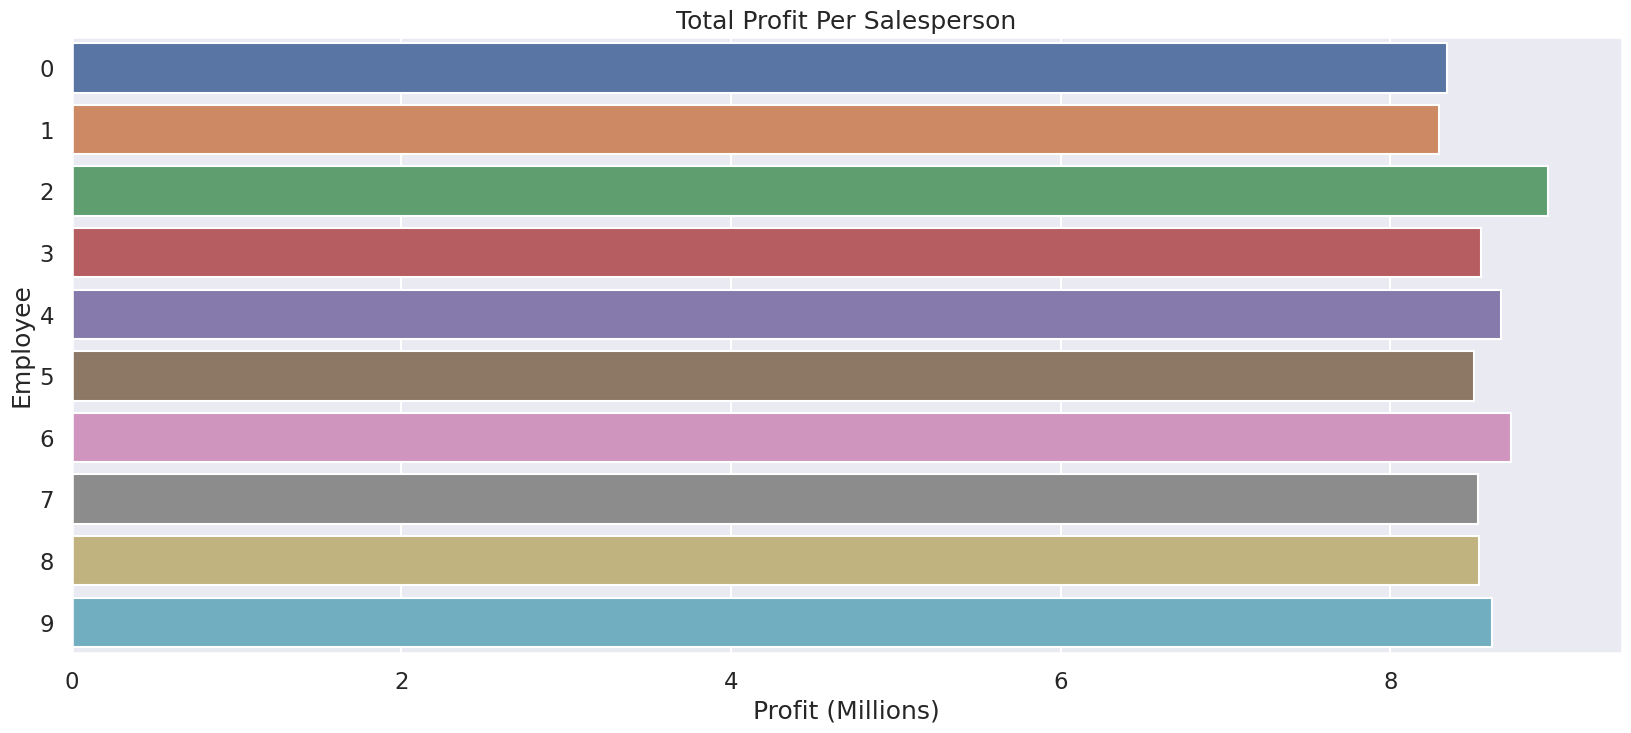

In [60]:
figure, ax = plt.subplots(
    figsize=(20,8)
)

sns.barplot(
    y="Employee",
    x="Profit (Millions)",
    data=total_profit_per_employee,
    orient="horizontal",
    ax=ax,
)

plt.title("Total Profit Per Salesperson");

### Yearly Profits Per Salesperson

In [71]:
yearly_profit_per_employee = df.groupby(["Employee", "Fiscal Year"], dropna=False)["Profit (Millions)"].sum().sort_values(ascending=False).reset_index().fillna("Unknown")

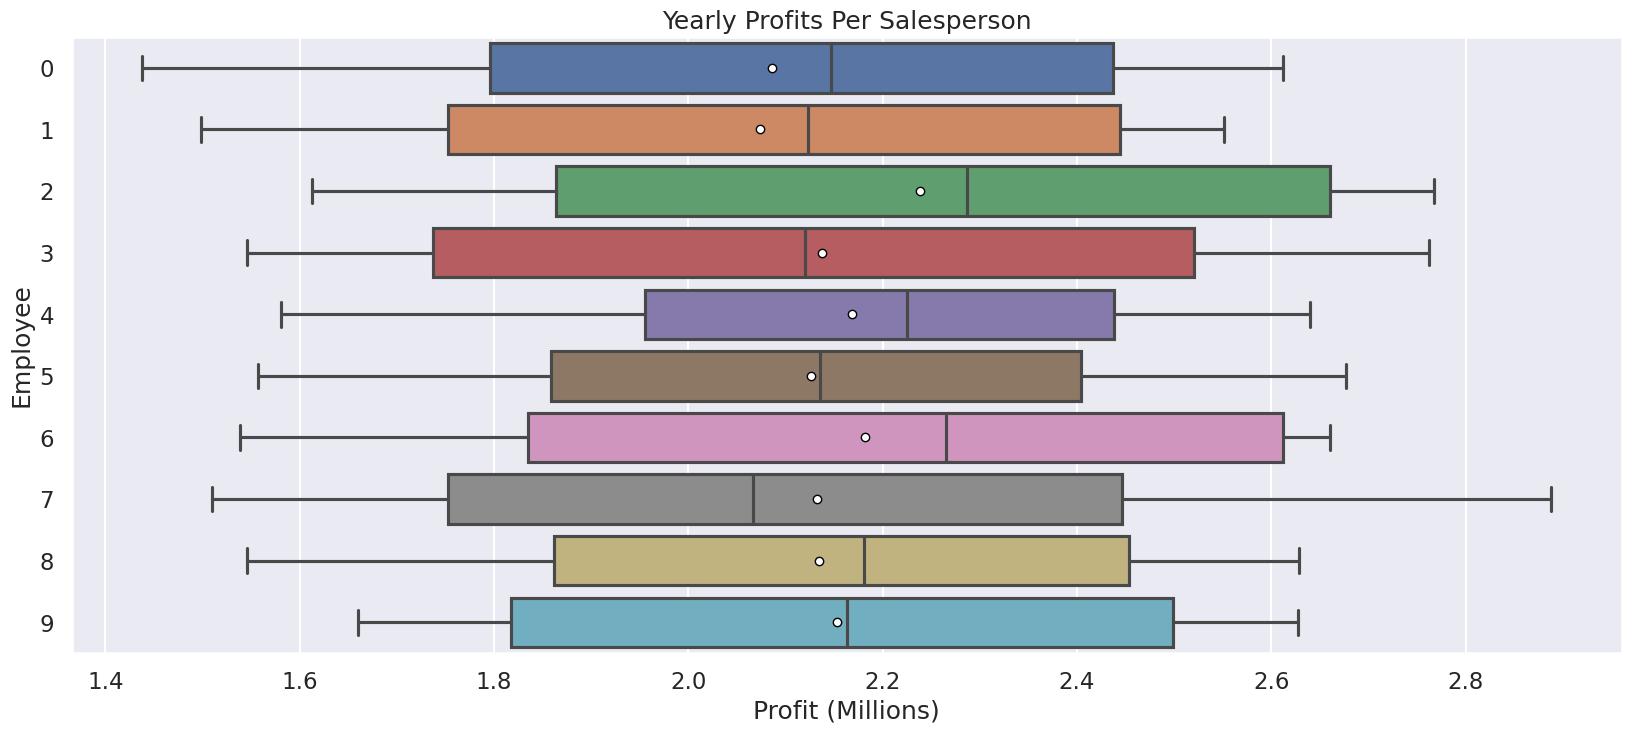

In [72]:
figure, ax = plt.subplots(
    figsize=(20,8)
)

sns.boxplot(
    y="Employee",
    x="Profit (Millions)",
    data=yearly_profit_per_employee,
    showmeans=True,
    meanprops={
        "marker": "o",
        "markerfacecolor": "white",
        "markeredgecolor": "black",
    },
    orient="h",
    ax=ax,
)

plt.title("Yearly Profits Per Salesperson");

### Monthly Profits Per Salesperson

In [73]:
monthly_profit_per_employee = df.groupby(["Employee", "Date"], dropna=False)["Profit (Thousands)"].sum().sort_values(ascending=False).reset_index().fillna("Unknown")
monthly_profit_per_employee["Date"] = monthly_profit_per_employee["Date"].dt.to_period('M').astype(str)

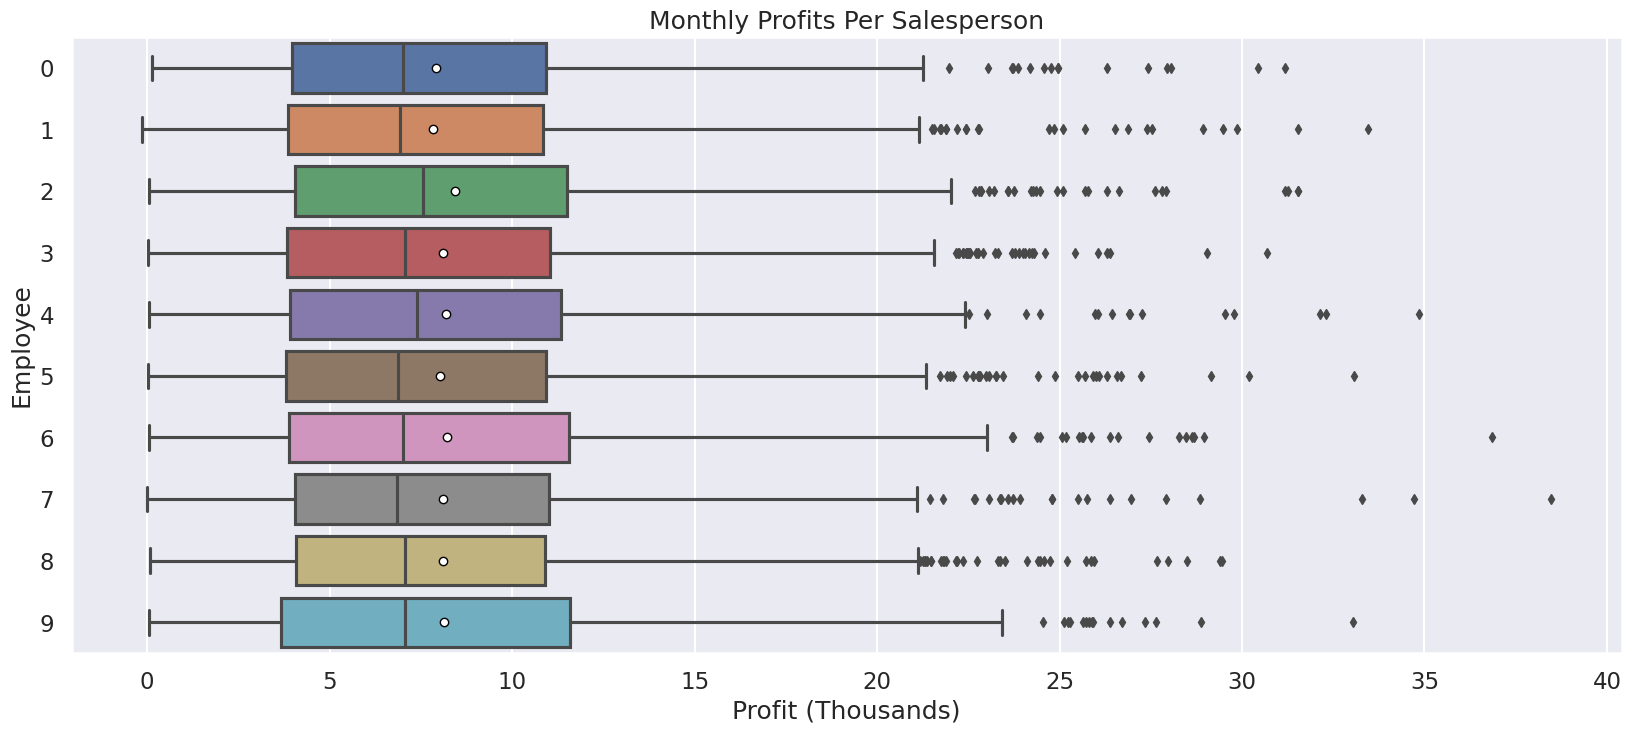

In [74]:
figure, ax = plt.subplots(
    figsize=(20,8)
)

sns.boxplot(
    y="Employee",
    x="Profit (Thousands)",
    data=monthly_profit_per_employee,
    showmeans=True,
    meanprops={
        "marker": "o",
        "markerfacecolor": "white",
        "markeredgecolor": "black",
    },
    orient="h",
    ax=ax,
)

plt.title("Monthly Profits Per Salesperson");

## Discussion and Future Work

There is inherent value in the data warehouse. However, the quality of the data is limiting its potential for more insightful analyses. For example, there were errors in the in the data that required some adhoc preprocessing to fix before analysis was possible. Even after preprocessing, there was missing data that couldn't be fixed easily, such as missing customer and product information.

- Improve data quality to ensure the maximum amount of information can be extracted for analyses.
    - Enforcing more stringent schemas on the data such that future data requires less preprocessing to become useful for analysis.
    - Ensuring existing data pipelines are functioning as intended.
    - Find ways to backfill missing data in existing records without unintentionally biasing the dataset with incorrect information.
- Move visualizations to an interactive dashboard for regular live monitoring.
- Improve accuracy of predictions/use more complex models where appropriate.
- Move data and analyses into the cloud for scalability.
    - Analyses presented were run locally on a single machine due to small data sizes. However, as the data grows this will become unsustainable in the long run.